**앙상블 학습과 랜덤 포레스트**

무작위로 선택된 무수히 많은 대답은 전문가의 답보다 나음
- 이를 **대중의 지혜**라고 함
- 이와 같이 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음
    - 이를 **앙상블**이라고 부름
    

---
- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킴
- 가장 많은 선택을 받은 클래스를 예측으로 삼음
- 결정 트리의 앙상블을 **랜덤 포레스트**라고 함

**배깅, 부스팅, 스태킹**등의 앙상블 방법

# 투표 기반 분류기

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것임
- 다수결 투표로 정해지는 분류기를 **직접 투표**분류기라고 함
- 정확도가 높은 경우가 많음

**약한 학습기** -> **강한 학습기**

**큰 수의 법칙** : 더 많이 던질수록 다수가 될 확률이 증가함

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

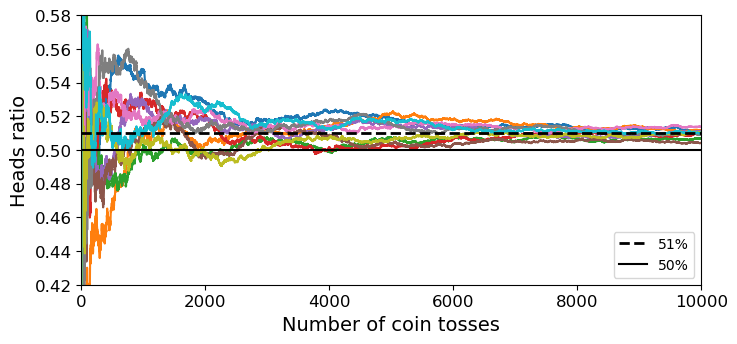

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

- 많이 던지면 던질수록 51%에 가까워지는 것을 볼 수 있음

- 이와 같이 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정하면 
    - 75%의 정확도를 기대할 수 있음
    - **단 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 함**
        - 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음
        - 분류기가 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블 정확도가 낮아짐

---
- 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드임

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
estimators=[('lr', log_clf),('rf',rnd_clf), ('svc', svm_clf)],
voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


- 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음
    - 이를 **간접 투표**라고 함
    - 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
    - 이 방식을 사용하기 위해서는 voting="hard"를 voting="soft"로 바꾸면 됨

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅과 페이스팅

- 다른 훈련 알고리즘 사용하여 다양한 분류기 만들기
- 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키기

1. **배깅** : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
2. **페이스팅** : 중복을 허용하지 않고 샘플링 하는 방식

- 배깅과 페이스팅에서는 같은 훈련 샘플이 여러 개의 예측기에 걸쳐 사용할 수 있음
- 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음

---
- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
- 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**이고 회귀에 대해서는 평균을 계산함
- 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

위 코드는 결정 트리 분류기 500개의 앙상블 훈련시키는 코드임
- 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨(페이스팅을 사용하려면 bootstrap=False로 설정)

In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

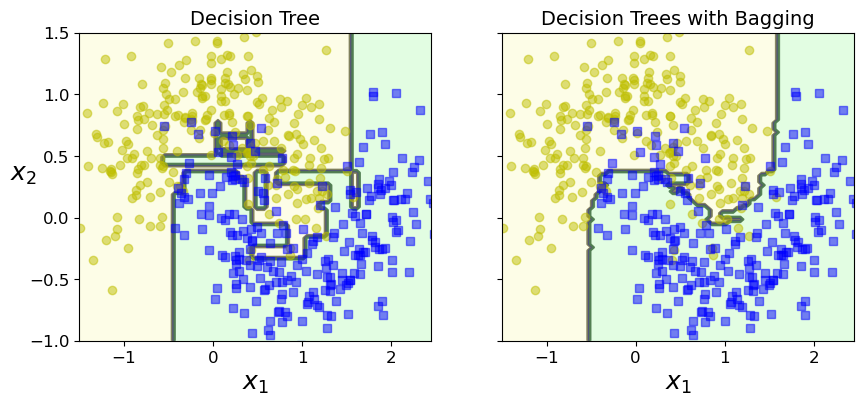

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- 왼쪽은 단일 결정 트리의 결정 경계
- 오른쪽은 500개의 트리를 사용한 배깅 앙상블의 결정 경계
---
- 앙상블이 일반화가 더 잘 되고 비슷한 편향에서 더 작은 분산을 만듦

- 훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
    - 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴
- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함

## oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
- BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택함
- 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미함
- 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out-of-bag)샘플이라고 부름
    - 예측기마다 남겨진 37%는 모두 다름

- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [14]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

- oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있음
- oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 68.25%로 추정하고 있음

In [16]:
bag_clf.oob_decision_function_

array([[0.36312849, 0.63687151],
       [0.41358025, 0.58641975],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07446809, 0.92553191],
       [0.31547619, 0.68452381],
       [0.01169591, 0.98830409],
       [0.99447514, 0.00552486],
       [0.97633136, 0.02366864],
       [0.7740113 , 0.2259887 ],
       [0.01724138, 0.98275862],
       [0.8372093 , 0.1627907 ],
       [0.83060109, 0.16939891],
       [0.953125  , 0.046875  ],
       [0.04733728, 0.95266272],
       [0.00540541, 0.99459459],
       [0.96938776, 0.03061224],
       [0.91860465, 0.08139535],
       [0.98360656, 0.01639344],
       [0.02970297, 0.97029703],
       [0.32795699, 0.67204301],
       [0.9027027 , 0.0972973 ],
       [1.        , 0.        ],
       [0.95187166, 0.04812834],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.66111111, 0.33888889],
       [0.

# 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원함
- 샘플링은 max_features, bootstrap_features 두 매개변수로 조절됨
- 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링임
    - 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨

- 매우 고차원의 데이터셋을 다룰 때 유용함(이미지와 같은)
- 훈련 특성과 샘플을 모두 샘플링하는 것을 **랜덤 패치 방식**이라고 함
- 훈련 샘플을 모두 사용하고(bootstrap=False이고 max_samples=1.0로 설정) 특성은 샘플링하는 (bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정) 것을 **랜덤 서브스페이스 방식**이라고 함
- 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

# 랜덤 포레스트

일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블임
- 전형적으로 max_samples를 훈련 세트의 크기로 지정함
- BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- RandomForestClassifier는 몇 가지 예외가 있지만 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있음
- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함
- 즉, 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듦

In [19]:
# BaggingClassifier를 사용해 랜덤포레스트 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

## 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함
- 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택함
---
- 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤 프리(엑스트라 트리)**라고 부름
- 편향이 늘어나지만 대신 분산을 낮춤
- 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름

ExtratreesClassifier를 사용함

## 특성 중요도

특성의 상대적 중요도를 측정하기 쉬움
- 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함
    - 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
---
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함
- features_importances_에 저장되어 있음

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09934873593966811
sepal width (cm) 0.02288187581472086
petal length (cm) 0.4167536451372604
petal width (cm) 0.46101574310835064


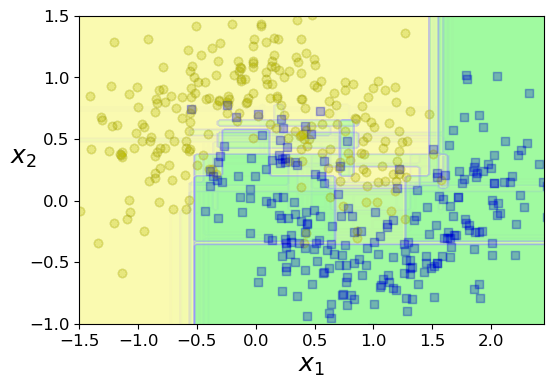

In [21]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [23]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [24]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

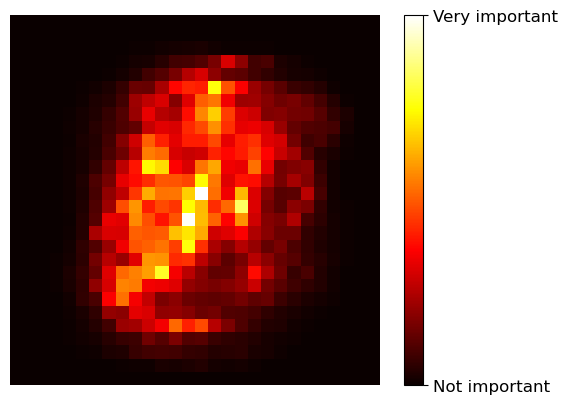

In [25]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

# save_fig("mnist_feature_importance_plot")
plt.show()

_위는 MNIST 픽셀 중요도를 나타냄_

# 부스팅

**부스팅**은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법을 말함
- 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
- **에이다부스트 (adaptive boosting의 줄임말)**와 **그레이디언트 부스팅**이 인기가 많음

## 에이다부스트

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것임
- 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨


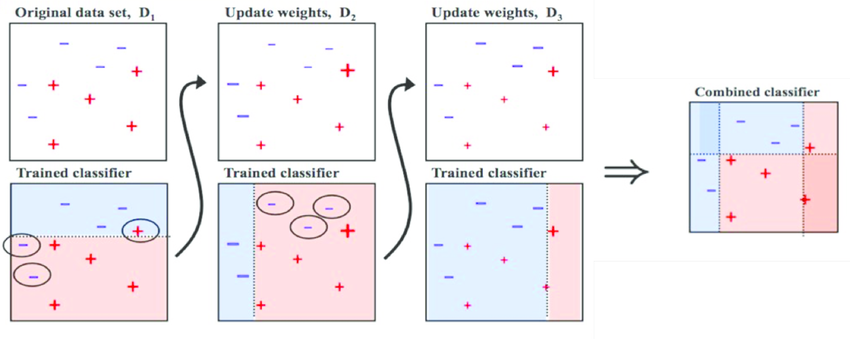

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

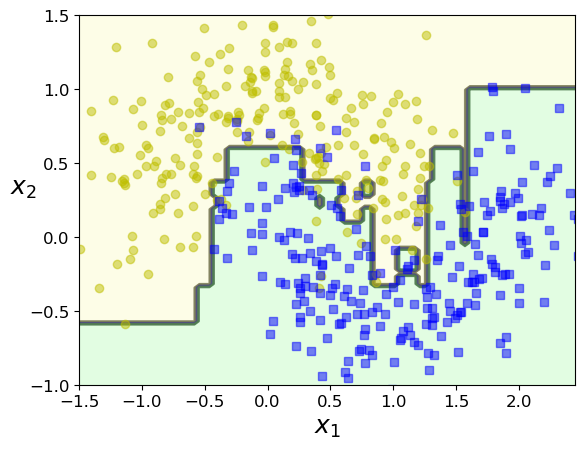

In [27]:
plot_decision_boundary(ada_clf, X, y)

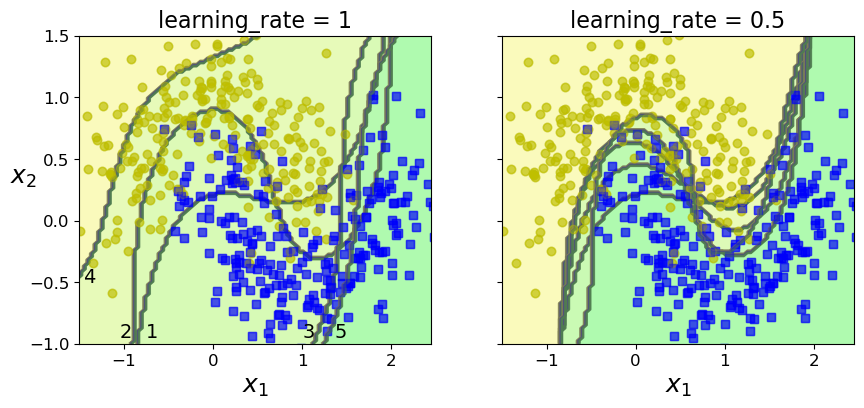

In [28]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

# save_fig("boosting_plot")
plt.show()

- 가중치를 가해 더 좋은 학습기를 가짐
- lr조정할 수 있음
- 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함

- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦
- 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

<font color="blue">j번째 예측기의 가중치가 적용된 에러율

$r_j=\frac{\sum^m_{i=1, \hat{y}^{(i)}_j\neq y^{(i)}}w^{(i)}}{\sum^m_{i=1}w^{(i)}}$

여기서 $\hat{y}^{(i)}_j$는 i번째 샘플에 대한 j번째 예측기의 예측

- 예측기의 가중치 $\alpha_j$는 아래와 가치 계산됨
- $\eta$는 학습률 하이퍼파라미터임
- 예측기가 정확할수록 가중치가 더 높아짐

<font color="blue">예측기 가중치

$\alpha_j=\eta\mbox{log}\frac{1-r_j}{r_j}$

- 샘플의 가중치를 업데이트함
- 잘못 분류된 샘플의 가중치가 증가됨

<font color="blue">가중치 업데이트 규칙

$w^{(i)} \leftarrow \begin{cases}
w^{(i)} & \hat{y_j}^{(i)}=y^{(i)} 일 때\\
w^{(i)}\mbox{exp}(\alpha_j) & \hat{y_j}^{(i)}\neq y^{(i)} 일 때
\end{cases}$

여기서 $i=1,2,\cdots,m$

- 그런 다음 모든 샘플의 가중치를 정규화함 (즉, $\sum^m_{i=1}w^{(i)}$로 나눔)

- 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨
- 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨

- 예측을 할 때 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만듦
- 가중치 합이 가장 큰 클래스가 예측 결과가 됨

<font color="blue">에이다부스트 예측

$\hat{y}(x)=\mbox{argmax}\sum_{j=1, \hat{y}_j(x)=k}^N\alpha_j$

여기서 N은 예측기 수

In [29]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

- SAMME.R은 SAMME의 변종이며 예측값 대신 클래스 확률에 기반하여 일반적인 성능이 더 좋음

## 그레이디언트 부스팅

에이다부스트처럼 그레이디언트 부스팅은 앙상블 이전까지 오차를 보정하도록 예측기를 순차적으로 추가함
- 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킴

- 결정 트리를 기반 예측기로 사용하는 회귀를 **그레이디언트 트리 부스팅**, **그레이디언트 부스티드 회귀 트리(GBRT)**라고 함

In [36]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

- 세 개의 트리를 포함하는 앙상블 모델이 생김


In [39]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [41]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

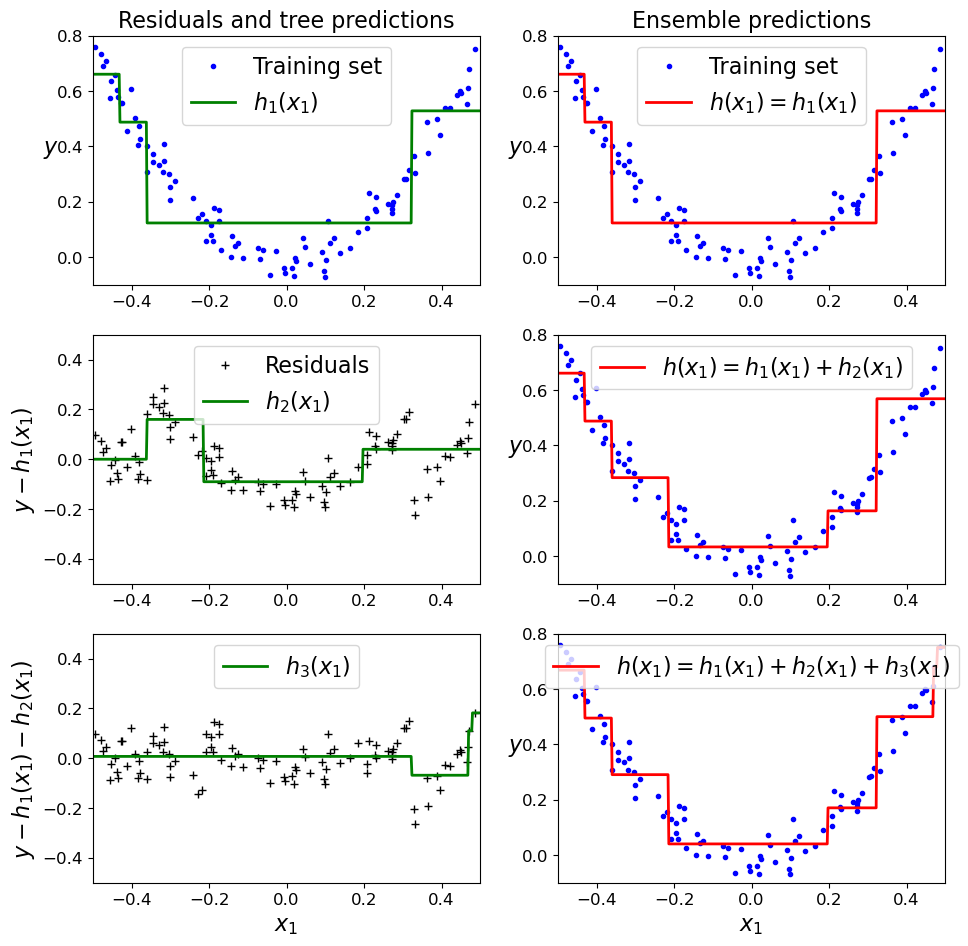

In [42]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

- 왼쪽 열은 세 트리의 예측이고 오른쪽 열은 앙상블의 예측임
- 트리가 앙상블에 추가될수록 앙상블의 예측이 더 좋아지는 것을 볼 수 있음

- 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있음

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수가 각 트리의 기여 정도를 조절함
- 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 예측의 성능이 좋아짐
    - **축소**라고 부르는 규제 방법임

In [44]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

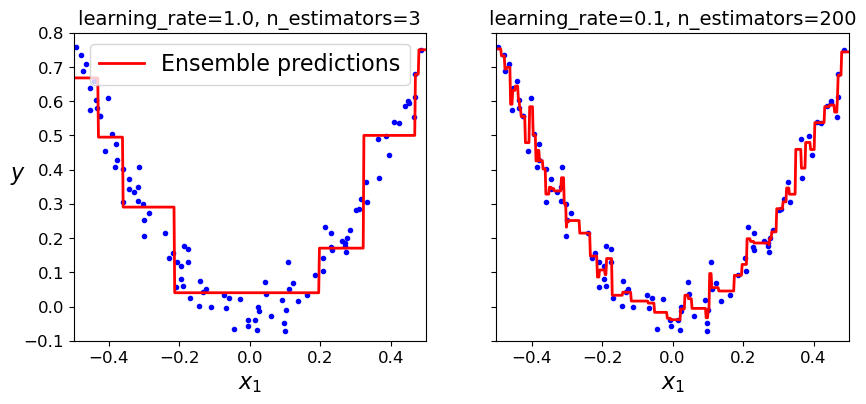

In [45]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("gbrt_learning_rate_plot")
plt.show()

- 왼쪽은 트리가 적고, 오른쪽은 트리가 너무 많음

- 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음
- staged_predict() 메서드를 사용함
    - 이 메서드는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환함
    

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=83)

In [49]:
min_error = np.min(errors)

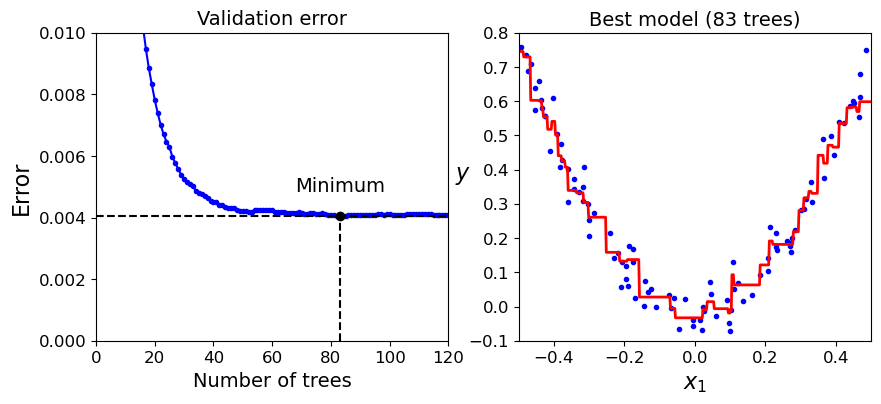

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

# save_fig("early_stopping_gbrt_plot")
plt.show()

- 왼쪽이 검증 오차이고 오른쪽은 최적 모델의 예측임

- 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수 있음
- warm_start = True로 설정하면 사이킷런이 fit()메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있게 해줌
- 다음 코드는 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춤

In [51]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else :
        error_going_up += 1
        if error_going_up == 5:
            break # 조기 종료

In [52]:
print(gbrt.n_estimators)

58


**확률적 그레이디언트 부스팅**
- 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원함
- subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨
- 편향이 높아지는 대신 분산이 낮아지게 됨
- 훈련속도를 높임


**XGBoost**
- 최적화된 그레이디언트 부스팅
- XGBoost는 익스트림 그레이디언트 부스팅의 약자
- BMLC 커뮤니티의 일원인 톈치 천이 개발함
- 매우 빠른 속도, 확장성, 이식성임

In [53]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [54]:
xgb_reg.fit(X_train, y_train, 
           eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.24330
[1]	validation_0-rmse:0.18183
[2]	validation_0-rmse:0.13927
[3]	validation_0-rmse:0.10731
[4]	validation_0-rmse:0.08964
[5]	validation_0-rmse:0.07995
[6]	validation_0-rmse:0.07352
[7]	validation_0-rmse:0.07097
[8]	validation_0-rmse:0.07019
[9]	validation_0-rmse:0.06928
[10]	validation_0-rmse:0.06825
[11]	validation_0-rmse:0.06856
[12]	validation_0-rmse:0.06892


C:\Users\hansol\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


- 조기 종료도 있음

# 스태킹

**스태킹**
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킴
- 마지막 예측기(**블렌더** 또는 **메타 학습기**)가 예측을 받아 최종 예측을 만듦

- 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것임
- 훈련 세트를 두 개의 서브셋으로 나누고 
    - 첫 번째 서브셋은 예측을 훈련시키며
    - 두 번재 서브셋에 대한 예측을 만듦(이 때 만들어진 예측은 완전히 새로운 것임)
    - 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음

---
- 블렌더를 여러 개 훈련시키는 것도 가능함 (하나는 선형 회귀, 하나는 랜덤 포레스트 회귀 등)
    - 블렌더만의 레이어가 만들어짐

_sklearn에서는 블렌더를 직접 지원하지 않음_